In [13]:
#import math modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import surprise modules
from surprise.prediction_algorithms.random_pred import NormalPredictor
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import evaluate, print_perf
from surprise import GridSearch
from surprise import accuracy

#Graphing
%matplotlib inline

In [14]:
#Setup functions to split data for testing and training
from sklearn.model_selection import train_test_split

def pick_users_books(df, num_users, num_books):
    #Get the top num_users most prolific users
    user_counts = pd.DataFrame(df.user_id.value_counts()).sort_values('user_id', ascending=False)
    top_10K_users = list(user_counts[0:num_users].index)
    user_filtered_df = df[df.user_id.isin(top_10K_users)]
    #Get the top num_books most reviewed books by the selected users
    filtered_book_counts = pd.DataFrame(user_filtered_df.book_id.value_counts()).sort_values('book_id', ascending = False)
    top_100_filtered_books = list(filtered_book_counts[0:num_books].index)
    #Generate new filtered dataframe
    filtered_df = user_filtered_df[user_filtered_df.book_id.isin(top_100_filtered_books)]
    print("New dataframe has {} users, {} items, and a sparsity of {}".format(len(filtered_df.user_id.unique()),len(filtered_df.book_id.unique()),len(filtered_df)/(len(filtered_df.user_id.unique())*len(filtered_df.book_id.unique()))))
    #Split dataframe into training and test sets
    train, test = train_test_split(filtered_df, test_size = 0.2, random_state=42)
    return train, test

def get_all_subsets(df):
    #Generate different subsets for scaling purposes
    train_500_20, test_500_20 = pick_users_books(df, 500, 20)
    train_2000_50, test_2000_50 = pick_users_books(df, 2000, 50)
    train_10000_100, test_10000_100 = pick_users_books(df, 10000, 100)

    return train_500_20, test_500_20, train_2000_50, test_2000_50, train_10000_100, test_10000_100

In [15]:
#Set up functions to nicely display gridsearch data in a table
#Need to do results_df = pd.DataFrame.from_dict(grid_search.cv_results)

#Function for alternating least squares
def convert_grid_results_als(df):

    my_dict = df.to_dict('list')
    method = []
    reg_i = []
    reg_u = []
    n_epochs = []
    
    for x in range(len(my_dict['bsl_options'])):
        y = my_dict['bsl_options'][x]
        method.append(y['method'])
        reg_i.append(y['reg_i'])    
        reg_u.append(y['reg_u'])
        n_epochs.append(y['n_epochs'])

    del my_dict['params']
    del my_dict['scores']
    del my_dict['bsl_options']

    my_dict['method'] = method
    my_dict['reg_i'] = reg_i
    my_dict['reg_u'] = reg_u
    my_dict['n_epochs'] = n_epochs
    my_df = pd.DataFrame.from_dict(my_dict).sort_values('RMSE')

    return my_df

#Function for gradient descent
def convert_grid_results_sgd(df):

    my_dict = df.to_dict('list')
    method = []
    reg = []
    learning_rate = [] 
    n_epochs = []

    for x in range(len(my_dict['bsl_options'])):
        y = my_dict['bsl_options'][x]
        method.append(y['method'])
        reg.append(y['reg'])        
        learning_rate.append(y['learning_rate'])
        n_epochs.append(y['n_epochs'])

    del my_dict['params']
    del my_dict['scores']
    del my_dict['bsl_options']

    my_dict['method'] = method
    my_dict['reg'] = reg    
    my_dict['learning_rate'] = learning_rate
    my_dict['n_epochs'] = n_epochs
    my_df = pd.DataFrame.from_dict(my_dict).sort_values('RMSE')

    return my_df

In [16]:
#load ratings data
ratings = pd.read_csv('../ratings.csv')

In [57]:
#Split data into trainint and test sets of different sizes
train_500_20, test_500_20, train_2000_50, test_2000_50, train_10000_100, test_10000_100 = get_all_subsets(ratings)

#More datasets
tr1, t1 = pick_users_books(ratings, 1000, 35)
all_1000_35 = tr1.append(t1)
tr2, t2 = pick_users_books(ratings, 5000, 70)
all_5000_70 = tr2.append(t2)
tr4, t4 = pick_users_books(ratings, 7500, 85)
all_7500_85 = tr4.append(t4)

New dataframe has 487 users, 20 items, and a sparsity of 0.44260780287474333
New dataframe has 1981 users, 50 items, and a sparsity of 0.3745583038869258
New dataframe has 9980 users, 100 items, and a sparsity of 0.2719659318637275
New dataframe has 985 users, 35 items, and a sparsity of 0.4041189267585207
New dataframe has 4980 users, 70 items, and a sparsity of 0.32403614457831326
New dataframe has 7479 users, 85 items, and a sparsity of 0.2953682074514523


In [18]:
#Run the Normal predictor - no gridsearch needed
algo = NormalPredictor()
reader = Reader(rating_scale=(1,5))
train = Dataset.load_from_df(train_10000_100, reader)
test = Dataset.load_from_df(test_10000_100, reader)
train.split(n_folds=3)
perf = evaluate(algo, train, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm NormalPredictor.

------------
Fold 1
RMSE: 1.3519
MAE:  1.0657
------------
Fold 2
RMSE: 1.3599
MAE:  1.0734
------------
Fold 3
RMSE: 1.3569
MAE:  1.0686
------------
------------
Mean RMSE: 1.3562
Mean MAE : 1.0693
------------
------------


In [19]:
#Grid search for baseline - gradient descent
param_grid = {'bsl_options':{'method': ['sgd'], 'reg':[.02,.01,.05], 'learning_rate':[.005,.001, .01], 'n_epochs':[10,20,40]}}
gridsearch = GridSearch(BaselineOnly, param_grid, measures=['RMSE', 'MAE'], verbose=0)
reader = Reader(rating_scale=(1,5))
train = Dataset.load_from_df(train_10000_100, reader)
test = Dataset.load_from_df(test_10000_100, reader)
train.split(n_folds=3)
gridsearch.evaluate(train)
convert_grid_results_sgd(pd.DataFrame.from_dict(gridsearch.cv_results))

[{'bsl_options': {'n_epochs': 10, 'method': 'sgd', 'learning_rate': 0.005, 'reg': 0.02}}, {'bsl_options': {'n_epochs': 10, 'method': 'sgd', 'learning_rate': 0.005, 'reg': 0.01}}, {'bsl_options': {'n_epochs': 10, 'method': 'sgd', 'learning_rate': 0.005, 'reg': 0.05}}, {'bsl_options': {'n_epochs': 10, 'method': 'sgd', 'learning_rate': 0.001, 'reg': 0.02}}, {'bsl_options': {'n_epochs': 10, 'method': 'sgd', 'learning_rate': 0.001, 'reg': 0.01}}, {'bsl_options': {'n_epochs': 10, 'method': 'sgd', 'learning_rate': 0.001, 'reg': 0.05}}, {'bsl_options': {'n_epochs': 10, 'method': 'sgd', 'learning_rate': 0.01, 'reg': 0.02}}, {'bsl_options': {'n_epochs': 10, 'method': 'sgd', 'learning_rate': 0.01, 'reg': 0.01}}, {'bsl_options': {'n_epochs': 10, 'method': 'sgd', 'learning_rate': 0.01, 'reg': 0.05}}, {'bsl_options': {'n_epochs': 20, 'method': 'sgd', 'learning_rate': 0.005, 'reg': 0.02}}, {'bsl_options': {'n_epochs': 20, 'method': 'sgd', 'learning_rate': 0.005, 'reg': 0.01}}, {'bsl_options': {'n_epo

,RMSE,learning_rate,method,n_epochs,reg
10,0.896817,0.005,sgd,20,0.01
20,0.896881,0.005,sgd,40,0.05
9,0.896881,0.005,sgd,20,0.02
11,0.897163,0.005,sgd,20,0.05
18,0.897200,0.005,sgd,40,0.02
19,0.897356,0.005,sgd,40,0.01
7,0.898463,0.010,sgd,10,0.01
6,0.898544,0.010,sgd,10,0.02
17,0.898547,0.010,sgd,20,0.05
15,0.898816,0.010,sgd,20,0.02


In [20]:
#Grid search for baseline - alternating least squares
param_grid = {'bsl_options':{'method': ['als'], 'reg_i':[5,10,20], 'reg_u':[10,15,20], 'n_epochs':[5,10,20]}}
gridsearch = GridSearch(BaselineOnly, param_grid, measures=['RMSE', 'MAE'], verbose=0)
reader = Reader(rating_scale=(1,5))
train = Dataset.load_from_df(train_500_20, reader)
test = Dataset.load_from_df(test_500_20, reader)
train.split(n_folds=3)
gridsearch.evaluate(train)
convert_grid_results_als(pd.DataFrame.from_dict(gridsearch.cv_results))

[{'bsl_options': {'reg_i': 5, 'method': 'als', 'reg_u': 10, 'n_epochs': 5}}, {'bsl_options': {'reg_i': 5, 'method': 'als', 'reg_u': 10, 'n_epochs': 10}}, {'bsl_options': {'reg_i': 5, 'method': 'als', 'reg_u': 10, 'n_epochs': 20}}, {'bsl_options': {'reg_i': 5, 'method': 'als', 'reg_u': 15, 'n_epochs': 5}}, {'bsl_options': {'reg_i': 5, 'method': 'als', 'reg_u': 15, 'n_epochs': 10}}, {'bsl_options': {'reg_i': 5, 'method': 'als', 'reg_u': 15, 'n_epochs': 20}}, {'bsl_options': {'reg_i': 5, 'method': 'als', 'reg_u': 20, 'n_epochs': 5}}, {'bsl_options': {'reg_i': 5, 'method': 'als', 'reg_u': 20, 'n_epochs': 10}}, {'bsl_options': {'reg_i': 5, 'method': 'als', 'reg_u': 20, 'n_epochs': 20}}, {'bsl_options': {'reg_i': 10, 'method': 'als', 'reg_u': 10, 'n_epochs': 5}}, {'bsl_options': {'reg_i': 10, 'method': 'als', 'reg_u': 10, 'n_epochs': 10}}, {'bsl_options': {'reg_i': 10, 'method': 'als', 'reg_u': 10, 'n_epochs': 20}}, {'bsl_options': {'reg_i': 10, 'method': 'als', 'reg_u': 15, 'n_epochs': 5}},

,RMSE,method,n_epochs,reg_i,reg_u
18,0.941916,als,5,20,10
19,0.941916,als,10,20,10
20,0.941916,als,20,20,10
9,0.942123,als,5,10,10
10,0.942123,als,10,10,10
11,0.942123,als,20,10,10
0,0.942422,als,5,5,10
1,0.942422,als,10,5,10
2,0.942422,als,20,5,10
21,0.952976,als,5,20,15


In [62]:
# Function to calculate spearman coefficient from surPRISE predictions
from scipy.stats import spearmanr
def spearman(predictions):
    dict_ratings = {}
    spearmans = []
    for uid, iid, true_r, est, _ in predictions:
        if float(true_r) and float(est) and not np.isnan(true_r) and not np.isnan(est):
            if uid in dict_ratings.keys():
                dict_ratings[uid][0].append(true_r)
                dict_ratings[uid][1].append(est)
            else:
                dict_ratings[uid]=[[true_r],[est]]
    for uid in dict_ratings.keys():
        if len(dict_ratings[uid][0])>1:
            spearman = spearmanr(dict_ratings[uid][0], dict_ratings[uid][1])[0]
            if np.isnan(spearman) == False: # spearman is NaN if all true ratings are the same! exclude these
                spearmans.append(spearman)
    return np.mean(spearmans)

In [82]:
import time

#Combine train and test sets
all_10000_100 = train_10000_100.append(test_10000_100)
all_500_20 = train_500_20.append(test_500_20)
all_2000_50 = train_2000_50.append(test_2000_50)


def runBaselineSGD(dataframe, num_users, num_books):
    n_ratings = len(dataframe)
    print("\nEvaluating for {} users and {} books; number of ratings: {}".format(num_users, num_books, n_ratings))
    
    #set up reader and get data from dataframe
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(dataframe[['user_id', 'book_id', 'rating']], reader)

    #Split data into training set, testing set, and the anti-test set (all the items neither in test nor train)
    trainset = data.build_full_trainset()
    testset = trainset.build_testset()
    antitestset = trainset.build_anti_testset()

    #Set up algorithm
    bsl_options = {'method': 'sgd', 'learning_rate':.005, 'n_epochs':20, 'reg':.01}
    algo = BaselineOnly(bsl_options = bsl_options)
    
    #Capture start time
    start_time = time.time()

    #Train algorithm
    algo.train(trainset)
    
    train_time = time.time() - start_time
    
    #Print training algorithm time
    print("---Training: %s seconds ---" % (train_time))

    #Capture start time - test
    start_time = time.time()
    
    #Get predictions
    predictions = algo.test(testset)
    
    test_time = time.time() - start_time
    
    #Print training algorithm time
    print("---Testing: %s seconds ---" % (test_time))

    #Evaluate accuracy measures
    rmse = accuracy.rmse(predictions, verbose=True)
    mae = accuracy.mae(predictions, verbose=True)
    accuracy.fcp(predictions, verbose=True)
    spman = spearman(predictions)
    print("SPEARMAN:  {}".format(spman))
    
    return [n_ratings, rmse, mae, spman, test_time, train_time]

running_tuples=[(all_500_20,500,20),(all_1000_35,1000,35),(all_2000_50,2000,50),(all_5000_70,5000,70),(all_7500_85,7500,85),(all_10000_100,10000,100)]

results_df = [[]]
for i in running_tuples:
    results_vector = runBaselineSGD(i[0],i[1],i[2])
    results_df.append(results_vector)


Evaluating for 500 users and 20 books; number of ratings: 4311
Estimating biases using sgd...
---Training: 0.01955413818359375 seconds ---
---Testing: 0.039104461669921875 seconds ---
RMSE: 0.8418
MAE:  0.6653
FCP:  0.6223


C:\Users\lohmu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3162: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\lohmu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3163: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\lohmu\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\lohmu\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\lohmu\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


SPEARMAN:  0.26246319425252296

Evaluating for 1000 users and 35 books; number of ratings: 13932
Estimating biases using sgd...
---Training: 0.05812716484069824 seconds ---
---Testing: 0.08122062683105469 seconds ---
RMSE: 0.8421
MAE:  0.6590
FCP:  0.6415
SPEARMAN:  0.2909718275843386

Evaluating for 2000 users and 50 books; number of ratings: 37100
Estimating biases using sgd...
---Training: 0.24271392822265625 seconds ---
---Testing: 0.21518683433532715 seconds ---
RMSE: 0.8432
MAE:  0.6586
FCP:  0.6421
SPEARMAN:  0.2833207893730011

Evaluating for 5000 users and 70 books; number of ratings: 112959
Estimating biases using sgd...
---Training: 0.9292392730712891 seconds ---
---Testing: 0.7792017459869385 seconds ---
RMSE: 0.8463
MAE:  0.6607
FCP:  0.6425
SPEARMAN:  0.28544749851890855

Evaluating for 7500 users and 85 books; number of ratings: 187770
Estimating biases using sgd...
---Training: 1.3984172344207764 seconds ---
---Testing: 1.2495782375335693 seconds ---
RMSE: 0.8570
MAE:  

In [87]:
results_df = pd.DataFrame(results_df[1:][:], columns=['n_ratings','rmse','mae','spearman','test_time','train_time'])

In [93]:
results_df

,n_ratings,rmse,mae,spearman,test_time,train_time
0,4311,0.841757,0.665276,0.262463,0.039104,0.019554
1,13932,0.842125,0.658996,0.290972,0.081221,0.058127
2,37100,0.843171,0.658559,0.283321,0.215187,0.242714
3,112959,0.846305,0.660739,0.285447,0.779202,0.929239
4,187770,0.856970,0.671885,0.290627,1.249578,1.398417
5,271422,0.858159,0.671075,0.297173,1.857234,2.107532


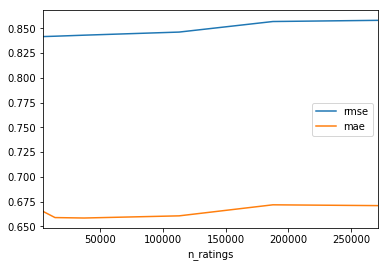

In [94]:
results_df[['n_ratings','rmse','mae']].plot(x='n_ratings',y=['rmse','mae'])

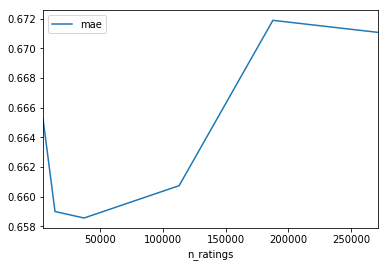

In [90]:
results_df[['n_ratings','mae']].plot(x='n_ratings',y='mae')

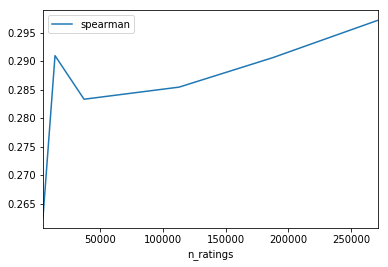

In [91]:
results_df[['n_ratings','spearman']].plot(x='n_ratings',y='spearman')

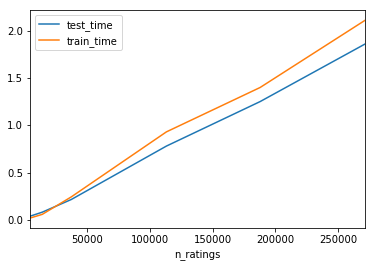

In [92]:
results_df[['n_ratings','test_time', 'train_time']].plot(x='n_ratings',y=['test_time','train_time'])